[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week7.ipynb)

# Week 7

This is the third Python programming homework for this course. You can do this homework either on Google colab, or on your own machine (after installing conda). Some general instructions for the exercises:

- In the description of every exercise we mention which functions you should use, and there will be a link to the relevant documentation. You are strongly encouraged to read the documentation, especially if you are not sure what the function does. 

- Each exersice consists of finishing some partially written code. The code you wrote is then automatically tested using a few `assert` statements. This is for your convenience, and you are requested __not to alter the tests__. If your code conforms to the instructions, and none of the tests throw an error, your answer is very likely to be correct. 

- It is possible to solve each exercise in no more than 10 lines of code, and most only need 2-3 lines. If your solution is much longer, you should try to make it shorter. In particular, don't forget that using vectorized `numpy` and `scipy` functions tends to produce shorter and much faster code than using nested Python `for` loops. 

- Before handing in, be sure to restart the IPython kernel (in colab: Runtime $\to$ Run all) and run the entire notebook top-to-bottom and check that none of the cells throw an error. 

Now we begin by running the cell below. Google colab by default uses an outdated version of CVXPY, and so we will need to update it. This may take about a minute, but this is only performed once per session. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [1]:
from importlib_metadata import version

if version('cvxpy')<'1.1.0':
   !pip install --upgrade cvxpy

import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (9, 6)
import numpy as np
import pandas as pd
import scipy

## Exercise 1

Two players play a game. 
- Every turn player 1 chooses a number $k\in\{1,\dots,n\}$ and player 2 chooses a number $l\in \{1,\dots,m\}$. 

- Player 1 pays $P_{kl}$ Swiss francs to player 2, where $P$ is an $n\times m$ matrix.  

- Player 1 chooses $k$ according to a probability distribution $\mathbb P(k=i) = u_i$, with $\sum_{i=1}^n u_i=1$ and $u_i\geq 0$, $\forall i$  

- Player 2 chooses $l$ (independently from player 1) according to a probability distribution $\mathbb P(l=i) = v_i$, with $\sum_{i=1}^n v_i=1$ and $v_i\geq 0$, $\forall i$  

- The matrix $P$ is known to both players. The goal for player 1 is to choose their strategy $u$ to minimize the expected money paid to player 2. The goal for player 2 is to choose $v$ to maximize the expected money earned from player 1.   

The expected amount player 1 pays to player 2 is given by
$$
\begin{align}
\mathbb E[P] &= \sum_{i=1}^n\sum_{j=1}^m P_{kl}\mathbb P(k=i,\,l=j)\\
&= \sum_{i=1}^n\sum_{j=1}^m P_{kl}u_iv_j\\
&= u^\top P v
\end{align}
$$

### Exercise 1a)
> Assume you are player 1, and assume the worst case scenario where player 2 knows which strategy you chose and adapts their strategy to counter yours.  
> Write a function `best_strategy_player1(P)` that takes the matrix $P$ as input, and as output gives the strategy of player 1 minimizing the following problem:
$$
    \begin{array}{ll}
    \text{minimize} & \sup \{ u^\top P v \mid v\geq 0,\,\sum_iv_i=1\}\\
    \text{subject to} & u\geq 0,\,\sum_i u_i=1
    \end{array}
$$

> First prove that this problem is equivalent to the LP below. Write your answer in the markdown cell below.
$$
    \begin{array}{ll}
        \text{minimize} & t\\
        \text{subject to} & -u\leq 0\\
        & P^\top u - t\mathbf 1\leq 0\\
        & \sum_i u_i -1 = 0
    \end{array}
$$  

___  

BEGIN SOLUTION

Note that $\sup \{ u^\top P v \mid v\geq 0,\,\sum_iv_i=1\}$ is attained when only one $v_i$ is nozero, namely the $v_i$ corresponding to $\max_i (P^\top u)_i$. Hence the problem is equivalent to
$$
    \begin{array}{ll}
    \text{minimize} & \max_i(P^\top u)\\
    \text{subject to} & u\geq 0,\,\sum_i u_i=1
    \end{array}
$$

This is in turn equivalent to the LP stated above.

END SOLUTION

In [43]:
def best_strategy_player1(P):
    n, m = P.shape

    # BEGIN SOLUTION

    u = cp.Variable(n)
    t = cp.Variable()
    objective = cp.Minimize(t)  # cp.max(P.T @ u))
    constraints = [u >= 0, cp.sum(u) == 1, P.T @ u <= t]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return u.value

    # END SOLUTION


P = np.array([[1, 2], [2, 3]])

print(f"Best strategy for P =\n {P}:")

best_strategy_player1(P)

Best strategy for P =
 [[1 2]
 [2 3]]:


array([1.00000000e+00, 1.50933113e-10])

In [44]:
def tests_1a():
    P = np.array([[1, 2], [2, 3]])
    strat = best_strategy_player1(P)
    assert (
        np.linalg.norm(strat - np.array([1, 0])) < 1e-6
    ), f"The best strategy for {P} is [1,0], not {strat}"

    np.random.seed(179)
    opt_strat_dict = {
        2: np.array([4.39580392e-09, 9.99999996e-01]),
        4: np.array([0.4102927, 0.25242817, 0.21473313, 0.12254599]),
        6: np.array(
            [
                1.09552936e-10,
                5.59919562e-11,
                9.83453635e-10,
                1.57090287e-09,
                6.83967885e-01,
                3.16032112e-01,
            ]
        ),
    }
    for n, m in zip([2, 4, 6], [2, 6, 4]):
        P = np.random.uniform(size=(n, m))
        strat = best_strategy_player1(P)
        assert np.min(strat) > -1e-4, "The strategy doesn't satisfy the constraints"
        assert (
            np.abs(np.sum(strat) - 1) < 1e-4
        ), "The strategy doesn't satisfy the constraints"
        assert (
            np.linalg.norm(strat - opt_strat_dict[n]) < 1e-4
        ), f"The optimal strategy for {P} is {opt_strat_dict[n]} and not {strat}"


tests_1a()

### Exercise 1b)
> Write down the Lagrangian $L(t,u,\lambda_1,\lambda_2,\nu)$ of the LP in problem 1a).
> Compute the dual function $g(\lambda_1,\lambda_2,\nu)$ and show that the dual problem of the LP in problem 1a) is given by
$$
    \begin{array}{ll}
        \text{maximize} & \nu\\
        \text{subject to} &\lambda_1\geq0, \lambda_2\geq0,\\
        &\mathbf 1^\top \lambda_2 =1,\\
        &P\lambda_2-\nu\mathbf 1=\lambda_1
    \end{array}
$$

> Type your answer in the markdown cell below  

___

BEGIN SOLUTION

The LP is already in standard form, so we can immediately write down the Lagrangian:
$$
\begin{align}
L(t,u,\lambda_1,\lambda_2,\nu) &= t + \lambda_1^\top (-u) + \lambda_2^\top(P^\top u - t\mathbf 1)+\nu(1-\mathbf 1^\top u)\\
&= \nu + (1-\mathbf 1^\top \lambda_2)t + (P\lambda_2 -\nu \mathbf 1 -\lambda_1)^\top u
\end{align}
$$  

The dual is given by $g(\lambda_1,\lambda_2,\nu) = \inf_{t,u}L(t,u,\lambda_1,\lambda_2,\nu)$. This infimum is unbounded below unless $1-\mathbf 1^\top \lambda_2=0$ and $P\lambda_2 -\nu \mathbf 1 -\lambda_1=0$, in which case $g(\lambda_1,\lambda_2,\nu) = \nu$. Hence

$$
g(\lambda_1,\lambda_2,\nu) = \left\{\begin{array}{ll} 
\nu & 1-\mathbf 1^\top \lambda_2=0 \text{, and } P\lambda_2 -\nu \mathbf 1 -\lambda_1=0\\ 
-\infty & \text{otherwise}
\end{array}\right.
$$

It then easily follows that the problem above is indeed the dual problem.

END SOLUTION

### Exercise 1c)
> Write a function `worst_case_payout` that solves the dual problem and returns the optimal value of $\nu$. 

> How is this optimal value related to the best strategy that you computed in 1a). Type your answer in the markdown cell below  

___

In [45]:
def worst_case_payout(P):
    n, m = P.shape

    # BEGIN SOLUTION

    nu = cp.Variable()
    lambda1 = cp.Variable(n)
    lambda2 = cp.Variable(m)

    objective = cp.Maximize(nu)
    constraints = [
        lambda1 >= 0,
        lambda2 >= 0,
        cp.sum(lambda2) == 1,
        P @ lambda2 - nu == lambda1,
    ]
    problem = cp.Problem(objective, constraints)

    problem.solve()

    return nu.value

    # END SOLUTION


P = np.array([[1, 2], [2, 3]])

print(f"Worst case payout for P =\n {P}:")

worst_case_payout(P)

Worst case payout for P =
 [[1 2]
 [2 3]]:


array(2.)

BEGIN SOLUTION

The optimal $\nu$ from 1c) correpsonds to the optimal value in 1a). This is to be expected since we have strong duality for an LP (and thus $d_* = p_*$).

END SOLUTION

In [46]:
def tests_1b():
    P = np.array([[1, 2], [2, 3]])
    nu = worst_case_payout(P)
    assert np.abs(nu - 2) < 1e-6, f"Worst case payout for {P} is 2, not {nu}"

    np.random.seed(179)
    opt_strat_dict = {
        2: 0.8682671292087011,
        4: 0.6428061261133738,
        6: 0.6183670319137122,
    }
    for n, m in zip([2, 4, 6], [2, 6, 4]):
        P = np.random.uniform(size=(n, m))
        nu = worst_case_payout(P)
        assert (
            np.abs(nu - opt_strat_dict[n]) < 1e-4
        ), f"Optimal payout for {P} is {opt_strat_dict[n]}, not {nu}"


tests_1b()

## Exercise 2

A two-dimensional skeir must slalom down a slope by going through $n$ parallel gates with known positions $(x_i,y_i)$ and width $c_i$ for $i=1,\dots, n$. The skier must start at a given position $(x_0,y_0)$ and end a position $(x_{n+1},y_{n+1})$.  

We want to find the shortest path the skier can take to go through all the gates. The skier has supernatural powers so that she can make instananeous turns. Her path is thus a piecewise linear function, and we can assume that the skier only changes direction inside of the gates. We can therefore write the path like this:
$$
    (x_0,y_0)=(x_0,t_0)\to (x_1,t_1)\to(x_2,t_2)\to\dots\to (x_n,t_n)\to(x_{n+1},t_{n+1})= (x_{n+1},y_{n+1})
$$

Below we show a valid path of the skier, going through the middle all the gates. It is clearly not the shortest path.

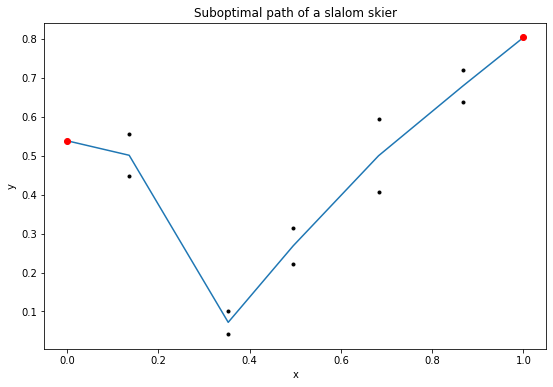

In [47]:
n = 5


def generate_slalom_course(n):
    x = np.linspace(0, 1, n + 2)
    x[1:-1] += np.random.uniform(low=-0.25 / (n + 2), high=0.25 / (n + 2), size=n)
    y = np.random.uniform(size=n + 2)
    c = np.random.uniform(low=0.05, high=0.2, size=n)

    return x, y, c


def plot_slalom_course(x, y, c, t):
    plt.plot(x[1:-1], y[1:-1] - c / 2, "k.")
    plt.plot(x[1:-1], y[1:-1] + c / 2, "k.")
    plt.plot(x, t)
    plt.plot((x[0], x[-1]), (y[0], y[-1]), "ro")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"The path of a slalom skier through {len(c)} gates")


np.random.seed(7)
x, y, c = generate_slalom_course(n)
t = y

plot_slalom_course(x, y, c, t)
plt.title("Suboptimal path of a slalom skier");

___  

> Write a function `slalom_path(x,y,c)` that outputs the $t$-values of the shortest path $(x_0, t_0),(x_1,t_1),\dots,(x_n,t_n),(x_{n+1},t_{n+1})$ as a vector of length $n+2$. 
> You should find a convex optimization problem that finds this path yourself, and solve it using `cvxpy`.  

___

Tips:  

- Use [cp.diff](https://www.cvxpy.org/api_reference/cvxpy.atoms.affine.html#diff) to obtain the differences of consecutive values of a vector.  

- Use [cp.vstack](https://www.cvxpy.org/api_reference/cvxpy.atoms.affine.html#vstack) to 'stack' multiple vectors into a matrix.  

- Use the `axis` keyword of [cp.norm](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#norm) to compute the norms of the rows or columns of a matrix.  

- If `x` is a vector, then `x[1:-1]` gives the vector with the first and last value removed.  

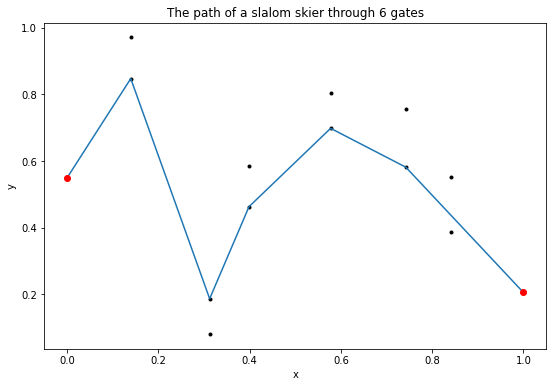

In [48]:
def slalom_path(x, y, c):
    n = len(x) - 2

    # BEGIN SOLUTION

    t = cp.Variable(n + 2)

    t_diffs = cp.diff(t)
    x_diffs = cp.diff(x)
    objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([t_diffs, x_diffs]), axis=0)))
    constraints = [t[0] == y[0], t[-1] == y[-1], cp.abs(t[1:-1] - y[1:-1]) <= c / 2]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return t.value

    # END SOLUTION


x, y, c = generate_slalom_course(6)
t = slalom_path(x, y, c)
plot_slalom_course(x, y, c, t)

In [49]:
def tests_2():
    np.random.seed(179)
    t_mean_dic = {
        6: 0.6929467789418455,
        7: 0.584999362175624,
        8: 0.6608071005820881,
        9: 0.5620933550452925,
    }
    try:
        for n in range(6, 10):
            x, y, c = generate_slalom_course(n)
            t = slalom_path(x, y, c)
            assert (
                np.abs(t[0] - y[0]) < 1e-5
            ), "The path doesn't start at the right point"
            assert (
                np.abs(t[-1] - y[-1]) < 1e-5
            ), "The path doesn't end at the right point"
            assert np.all(
                np.abs(y - t) - 1e-4 <= 0.1
            ), "The path doesn't go through all the gates"
            assert (
                np.mean(np.abs(t - y)) > 1e-3
            ), "The path going through the middle of all the gates is not optimal"

            assert np.abs(np.mean(t) - t_mean_dic[n]) < 1e-3, "The path is not optimal."

            c = c * 1e-6
            t = slalom_path(x, y, c)
            assert np.all(
                np.abs(y - t) <= 1e-3
            ), "The path doesn't go through all the gates when the gates are tiny"

            c = c + 2
            t = slalom_path(x, y, c)
            assert (
                np.linalg.norm(np.diff(np.diff(t) / np.diff(x))) < 1e-3
            ), "If the gates are very wide, a straight path is optimal."

    except AssertionError:
        print("Something went wrong in the situation plotted below:")
        plot_slalom_course(x, y, c, t)
        raise


tests_2()

## Exercise 3

Suppose you want to design a two-stage rocket to deliver a payload of mass $m_p$ into a low-earth orbit. Each rocket stage has an initial mass $m_{0,i}$ and a final mass $m_{1,i}$. The difference $m_{1,i}-m_{0,i}$ is the mass of the fuel. The rocket equation tells us that each stage of the rocket can give a change in velocity given by
$$
    \Delta v_i = v_e \log \frac{m_{0,i}}{m_{1,i}}
$$

where $v_e$ is the _effective exhaust velocity_, a measure of the fuel efficieny of the rocket. For a rocket with two stages, this means a total change in velocity of
$$
\begin{align}
    \Delta v = v_e \log \frac{m_{0,1}}{m_{1,1}} + v_e \log \frac{m_{0,2}}{m_{1,2}} =v_e \log \frac{m_{0,1}m_{0,2}}{m_{1,1}m_{1,2}}
\end{align}
$$

Each stage has a _dry weight_ of at least 10% the mass of the stage given by the mass of the fuel tanks and engines.
There are a few design constraints.  

- The first stage needs to carry the weight of the second stage in addition to its dry weight, this means that we have: $m_{1,1}\geq 0.1 m_{0,1}+m_{0,2}$.

- The second stage needs to carry payload (of mass $m_p$) in addition to its dry weight, hence $m_{1,2}\geq 0.1 m_{0,2}+ m_p$. 

- For any stage the initial weight is always more than the final weight: $m_{0,i}\geq m_{1,i}$.

- We need to reach orbital velocity (about 7.8 km/s). To also compensate for losses due to drag and gravity we require $\Delta v \geq 9.4\,\text{km}/\text{s}$. We will however solve the problem for arbitrary target $\Delta v$.

___

> We want to minimize the total weight $m_{1,1}+m_{1,2}$ of the rocket such that it still satisfies the design constraints.
> This problem is a geometric program.   
> Write a function `two_stage_rocket(exhaust_velocity, target_delta_v, payload_mass)` that solves the 
> design problem using CVXPY. It should return a list with the values of $(m_{0,1},\, m_{1,1},\, m_{0,2},\, m_{1,2})$.  

___  

Tips:  

- When solving a GP, you need to specify this by calling `problem.solve(gp=True)`.   

- When solving a GP, you need to tell CVXPY that your variables are positive by using `cp.Variable(pos=True)`.   

- Since we're using ratios of masses, and since $\Delta v$ and $v_e$ have the same units, you don't need to worry about units of the quantities.   

In [50]:
def two_stage_rocket(exhaust_velocity, target_delta_v, payload_mass):
    # BEGIN SOLUTION

    m01 = cp.Variable(pos=True)
    m11 = cp.Variable(pos=True)
    m02 = cp.Variable(pos=True)
    m12 = cp.Variable(pos=True)

    objective = cp.Minimize(m11 + m12)
    constraints = [
        exhaust_velocity * cp.log(m01 * m02 / (m11 * m12)) >= target_delta_v,
        m11 >= m02 + 0.1 * m01,
        m12 >= payload_mass + m02 * 0.1,
        m02 >= m12,
        m01 >= m11,
    ]

    problem = cp.Problem(objective, constraints)

    problem.solve(gp=True)

    m = (m01.value, m11.value, m02.value, m12.value)

    return m

    # END SOLUTION


two_stage_rocket(3.2, 9.4, 1)

(69.08225961890517, 11.47063382410245, 4.562407869965121, 1.4562407905915395)

In [51]:
def tests_3():
    answer_dic = {
        (3.2, 8.5, 1): 48.20675019857243,
        (3.2, 8.5, 10): 482.06749968213853,
        (3.2, 9.5, 1): 77.42781568860711,
        (3.2, 9.5, 10): 774.2781096439586,
        (3.6, 8.5, 1): 32.190783392460546,
        (3.6, 8.5, 10): 321.907825185365,
        (3.6, 9.5, 1): 47.02729452261383,
        (3.6, 9.5, 10): 470.2729286076839,
    }
    for exhaust_velocity in [3.2, 3.6]:
        for target_delta_v in [8.5, 9.5]:
            for payload_mass in [1, 10]:
                m = two_stage_rocket(exhaust_velocity, target_delta_v, payload_mass)
                m = np.array(m)
                assert len(m) == 4, "Return the four masses (m01, m11, m02, m12)"
                assert m[0] is not None, "CVXPY did not find a feasible point"
                assert np.all(
                    np.diff(m) < 0
                ), "The masses of consectuvive stages should be in decreasing order"
                assert np.all(
                    m > payload_mass
                ), "The final stage is lighter than the payload mass"
                total_mass = m[0] + m[2]
                correct_mass = answer_dic[
                    (exhaust_velocity, target_delta_v, payload_mass)
                ]
                assert (
                    np.abs(total_mass - correct_mass) / correct_mass < 1e-3
                ), f"""For paramaters {(exhaust_velocity, target_delta_v, payload_mass)}
                the correct mass is {correct_mass:.3f}, but got {total_mass:.3f}"""


tests_3()

Below we see that the total vehicle mass as function of the target $\Delta v$. With an effective exhaust velocity of $v_e = 3.2$ km/s and a 10% dry weight, we cannot design a rocket with more than about 14.7 km/s $\Delta v$. The amount of mass required increases more than exponentially with the target $\Delta v$. Most real-life rockets have three stages, since this can significantly decrease the mass of the rocket for the same $\Delta v$. Usually the second (and third) stages of a rocket also have higher effective exhaust velocities since rocket engines are more efficient in a vacuum.

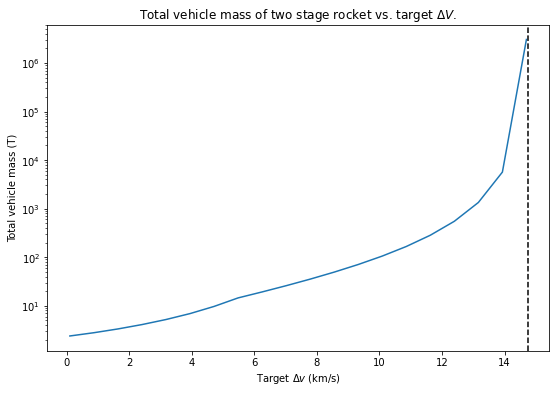

In [52]:
delta_v = np.linspace(0.1, 14.7, 20)
masses = np.array([two_stage_rocket(3.2, x, 1) for x in delta_v])
plt.plot(delta_v, masses[:, 0] + masses[:, 2])
plt.yscale("log")
plt.xlabel("Target $\Delta v$ (km/s)")
plt.ylabel("Total vehicle mass (T)")
plt.axvline(14.73654, c="k", ls="--")
plt.title("Total vehicle mass of two stage rocket vs. target $\Delta V$.");

## Exercise 4

Consider $k$ points $x_1,\dots,x_k$ in $\mathbb R^2$. For a given $d>0$, we define the $k$-ellipse with radius $d$ as the set of points $x\in \mathbb R^2$ such that 
$$
\left\{x\in \mathbb R^2\mid \sum_{i=1}^k \|x-x_i\| = d\right\}
$$

For small $d$, this set can be empty. The point $x^*$ that solves $\operatorname{min}_x \sum_{i=1}^k \|x-x_i\|$ is called the _geometric median_ of $X=(x_1,\dots, x_k)$. For more information, see also [Wikipedia](https://en.wikipedia.org/wiki/Geometric_median).

### Exercise 4a

> Write a function `geometric_median_problem(X)` which takes a matrix `X` of shape `(k,2)` as input and returns a CVXPY problem solving the geometric median problem for $X$. 
> This problem is an SOCP, and you are only allowed to use [cp.SOC](https://www.cvxpy.org/api_reference/cvxpy.constraints.html#soc) constraints.  
> You must use the variable `x` with `name='x'`.  

___  

Tips:

- First write the problem as an SOCP, for this you may need to introduce a new optimization variable. You do not have to write the SOCP in standard form.  

- An SOC constraint [cp.SOC](https://www.cvxpy.org/api_reference/cvxpy.constraints.html#soc) of form `cp.SOC(t,X)` means $\|X\|_2 \leq t$. It is recommended to create a seperate SOC constraint for each $1\leq i\leq k$.  

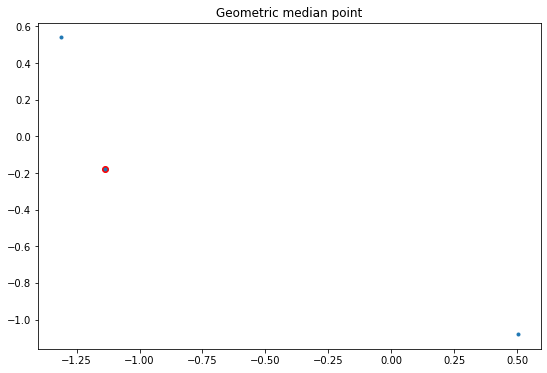

In [53]:
def geometric_median_problem(X):
    k = X.shape[0]
    x = cp.Variable(2, name="x")
    
    # BEGIN SOLUTION
    
    d = cp.Variable(k)
    objective = cp.Minimize(np.ones(k).T@d)
    constraints = [cp.SOC(d[i],X[i]-x) for i in range(k)]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return problem

    # END SOLUTION


def geometric_median(X):
    """Solve the geometric median problem and return minimum distance and optimal point"""
    problem = geometric_median_problem(X)
    d = problem.solve()
    x = [v.value for v in problem.variables() if v.name() == "x"][0]
    return d, x


k = 3
X = np.random.normal(size=(k, 2))

d, x = geometric_median(X)
plt.title("Geometric median point")
plt.plot([x[0]], [x[1]], "ro")
plt.plot(X[:, 0], X[:, 1], ".");

In [54]:
def tests_4a():
    np.random.seed(179)
    distance_dic = {
        1: 0,
        2: 2.6188843567660545,
        3: 1.1214175907750659,
        4: 3.25532276660768,
    }
    x_mean_dic = {
        1: 0.03900238975942678,
        2: -0.5489833285064573,
        3: 0.7783347685248139,
        4: 0.5494309633850374,
    }
    for k in range(1, 5):
        X = np.random.normal(size=(k, 2))
        problem = geometric_median_problem(X)
        assert isinstance(
            problem, cp.Problem
        ), f"You need to return a cp.Problem, instead got {type(problem)}"
        assert len(problem.constraints) > 0, "The optimizaton is unconstrained"
        assert np.all(
            [
                isinstance(c, cp.constraints.second_order.SOC)
                for c in problem.constraints
            ]
        ), "You can only use SOC constraints"
        d, x = geometric_median(X)
        correct_d = distance_dic[k]
        assert (
            np.abs(d - correct_d) < 1e-3
        ), f"Distance should be {correct_d:.3f} but got {d:.3f}"
        print(f"{k}: {np.mean(x)},")
        correct_mean = x_mean_dic[k]
        assert (
            np.abs(np.mean(x) - correct_mean) < 1e-3
        ), f"Distance should be {correct_mean:.3f} but got {np.mean(x):.3f}"


tests_4a()

1: 0.03900238975942678,
2: -0.5489833285064573,
3: 0.7783347685248139,
4: 0.5494309633850374,


### Exercise 4b)

Next we want to plot the $k$-ellipses associated to some points $X=(x_1,\dots,x_k)$. The easiest way to do this is to compute 
$$
f(x) = \sum_{i=1}^k \|x-x_i\|
$$

for many values of $x$ in a grid, and then look at contours $\{f(x)=d \mid x\in \mathbb R^2\}$.  

___  

> Finish the code for the function `plot_k_ellipse(X)` below.   
> Here `xx` and `yy` are the $x$ and $y$ values respectively of a 100x100 grid.  
> You should use [plt.contour](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) to plot a contour; be sure to read the documentation.  
> For the first two arguments use `xx` and `yy`, the third argument you will need to compute yourself.  

___  


Tips:

- You can do a for loop over all pairs of values `xx` and `yy`. The [zip](https://docs.python.org/3/library/functions.html#zip) function may be helpful.  

- There are no tests for this exercise. To verify for yourself if the code is correct, try varying the value of `k` used and see if the results make sense.  

In [68]:

k = 3
X = np.random.normal(size=(k, 2))
N_points = 100
xx = np.linspace(np.min(X) - 1, np.max(X) + 1, N_points)
yy = np.linspace(np.min(X) - 1, np.max(X) + 1, N_points)
xx, yy = np.meshgrid(xx, yy)



CPU times: user 22.7 s, sys: 3.09 s, total: 25.8 s
Wall time: 25.6 s


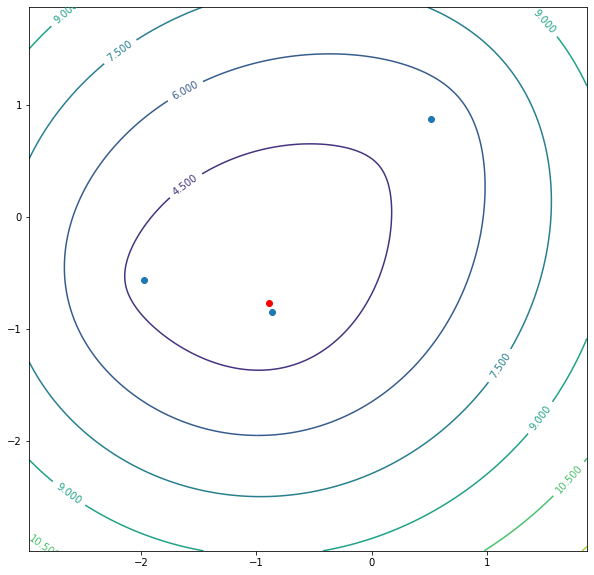

In [81]:
def plot_k_ellipse(X):
    N_points = 100
    xx = np.linspace(np.min(X) - 1, np.max(X) + 1, N_points)
    yy = np.linspace(np.min(X) - 1, np.max(X) + 1, N_points)
    xx, yy = np.meshgrid(xx, yy)
    
    plt.figure(figsize=(10,10))

    # BEGIN SOLUTION

    # Simple solution. 
    # For loops are slow in Python, so we want avoid big loops.
    # Time: 8.38s for N_points = 500
    # Z = np.zeros_like(xx)
    # for i in range(xx.shape[0]):
    #     for j in range(xx.shape[1]):
    #         for k in range(len(X)):
    #             Z[i,j] += np.linalg.norm(X[k] - np.array((xx[i,j],yy[i,j])))

    # Faster solution. If we want even faster, we should parallelize this.
    # Time: 138 ms for N_points=500
    xxyy = np.stack([xx,yy],axis=-1)
    Z = np.zeros_like(xx)
    for k in range(len(X)):
        Z+=np.linalg.norm(xxyy-X[k],axis=-1)

    CS = plt.contour(xx, yy, Z)

    # END SOLUTION

    plt.clabel(CS)  # Put labels on each contour
    plt.plot(X[:, 0], X[:, 1], "o")  # Plot the k points
    
    # If you completed exercise 4a), also show the geometric median
    try:
        d, x = geometric_median(X)
        plt.plot([x[0]], [x[1]], "ro")
    except:  # Never EVER use a bare except statement, except if you're the teacher :-)
        print("Geometric median not implemented.")


k = 3
X = np.random.normal(size=(k, 2))

plot_k_ellipse(X)